### TRAINING MODELS

In [1]:
# IMPORT EVERYTHING
#from Architectures.AE_ADJ import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)
from Architectures.AE_ADJ_v2 import AE  # for some reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load, load_middle_slices
from Visualizations.latent_space_projections import plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from sklearn.cluster import SpectralClustering
from scipy.stats import f_oneway
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, activations, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import time
import math
import nibabel as nib
import json
from tqdm import tqdm

In [46]:
#groups = {}
groups3D = {}
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    #groups[group]=np.load(open(f"Data/D2-{group}.npy","rb"))
    groups3D[group]=np.load(open(f"Data/D3-{group}.npy","rb"))

n = 10
g = groups3D.copy()
g["CN"] = g["CN"][0:n]
g["AD"] = g["AD"][0:n]
g["MCI"] = g["MCI"][0:n]

Opening faster: 100%|██████████| 3/3 [00:16<00:00,  5.46s/it]


In [64]:
"""
A2 = AE(name="A2", input_shape=groups["CN"].shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=False, optimizer="adam", loss_fn="mse").compile_model()
"""

"""
public_repo_mse_2d = AE(name="public_repo_2D_mse", input_shape=groups["CN"].shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, optimizer="adam", loss_fn=MSE_loss).compile_model()

public_repo_ssim_2d = AE(name="public_repo_2D_ssim", input_shape=groups["CN"].shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, optimizer="adam", loss_fn=SSIM_loss).compile_model()
"""

models_list = [
    AE(name="public_repo_autoencoder_3d_mse", input_shape=groups3D["CN"].shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 1,  (3, 3, 3), {'activation': 'sigmoid','padding': 'same'}),
    ], VAE_model=False, optimizer="adam", loss_fn=MSE_loss).compile_model()

]
"""
    AE(name="public_repo_autoencoder_3D_vae_mse", input_shape=groups3D["CN"].shape, latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
            (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
            (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
            (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
            (layers.Conv3D, 1,  (3, 3, 3), {'activation': 'sigmoid','padding': 'same'}),
        ],
    VAE_model=True, optimizer="adam", loss_fn=MSE_loss).compile_model(),
    
   AE(name="public_repo_autoencoder_3D_vae_ssim", input_shape=groups3D["CN"].shape, latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
            (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
            (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
            (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
            (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
            (layers.Conv3D, 1,  (3, 3, 3), {'activation': 'sigmoid','padding': 'same'}),
        ],
    VAE_model=True, optimizer="adam", loss_fn=SSIM_loss).compile_model(),
"""


Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 20, 24, 20, 128)


'\n    AE(name="public_repo_autoencoder_3D_vae_mse", input_shape=groups3D["CN"].shape, latent_dim=128,\n        encoder_layers=[\n            (layers.Conv3D, 32, (3, 3,3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization(),\n            (layers.Conv3D, 32, (3, 3,3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization(), (layers.MaxPooling3D, {\'pool_size\': (2, 2, 2)}),\n            (layers.Conv3D, 64, (3, 3,3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization(),\n            (layers.Conv3D, 64, (3, 3,3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization(), (layers.MaxPooling3D, {\'pool_size\': (2, 2, 2)}),\n            (layers.Conv3D, 128, (3, 3, 3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization(),\n            (layers.Conv3D, 128, (3, 3, 3), {\'activation\': \'relu\', \'padding\': \'same\'}), layers.BatchNormalization()\n        ],\n        d

In [65]:
for m in models_list: #[A2,A4,A5]
    m.train(g["CN"], epochs=10, batch_size=4, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images", 
    save_interval=3, patience=3)

Training public_repo_autoencoder_3d_mse on CPU
Input shape: (10, 80, 96, 80)
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 0.1678 - val_loss: 0.1585
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.1559 - val_loss: 0.1188
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.0962 - val_loss: 0.0379
Models saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3d_mse\epoch_3 as 'public_repo_autoencoder_3d_mse_autoencoder.keras', 'public_repo_autoencoder_3d_mse_encoder.keras', 'public_repo_autoencoder_3d_mse_decoder.keras'.
Loss history saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3d_mse\epoch_3\history.json
Model details saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3d_mse\epoch_3\configs.json
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.0308 - val_loss: 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - loss: 0.011

In [8]:
models_list = [public_repo_3d]

In [3]:
def find_clusters(data, n_clusters=3):
    """
    Perform clustering on MRI latent space data using Spectral Clustering and calculate p-values.
    
    Parameters:
    data (numpy.ndarray): A matrix of shape (n_samples, m_features).
    n_clusters (int): Number of clusters to form.
    
    Returns:
    tuple: Cluster labels for each sample, p-values for samples.
    """
    
    # Perform Spectral Clustering
    #spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10) # random_state=42
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', gamma=1.0)

    # import warnings
    # with warnings.catch_warnings():
    #     warnings.filterwarnings("ignore", message="Graph is not fully connected*")
    #     spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
    #     labels = spectral.fit_predict(data)

    labels = spectral.fit_predict(data)
    
    # Calculate p-values for each feature using ANOVA
    p_values_samples = []
    for i in range(data.shape[1]):
        feature_data = [data[labels == cluster, i] for cluster in range(n_clusters)]
        f_stat, p_value = f_oneway(*feature_data)
        p_values_samples.append(p_value)
    
    return labels, np.array(p_values_samples)

def Silhouette(data, labels):
    return silhouette_score(data, labels)

def Inertia(data, labels):
    # Inertia calculated using the labels from SpectralClustering
    inertia = 0
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        inertia += ((cluster_data - cluster_center) ** 2).sum()
    return inertia

def ARI(data, labels, true_labels):
    return adjusted_rand_score(true_labels, labels)

def compare_models(models_list, groups, reconstruction_metrics, clustering_metrics, n_runs=20):
    # To run this function
    # 1. add name to each model, model.name="something"
    # 2. add .VAE_model = True to your vae models, .VAE_model = false to others
    # 3. add in the encode(), decode() functions (you can copy from ae_adj_v2.py), or you can modify compare_models to your likings
    
    metric_results = []
    group_labels = {"CN": 0, "AD": 1, "MCI": 2}
    true_labels = []
    
    for label, image in groups.items():
        true_labels.extend([group_labels[label]] * image.shape[0])

    for i, model in enumerate(models_list):
        model_result = {"Model": model.name}

        for label, image in groups.items():
            latent = model.encode(image)
            recon = model.autoencode(image)

            for recon_metric in reconstruction_metrics:
                metric_name = f"{label}_{recon_metric.__name__}"
                metric_value = recon_metric(image, recon).numpy()
                model_result[metric_name] = metric_value
                print(f"Reconstruction metric computed: {metric_name}")

        combined_data = np.concatenate(list(groups.values()), axis=0)
        combined_data_scaled =  StandardScaler().fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
        
        latent = model.encode(combined_data_scaled)
        if model.VAE_model:
            latent = latent[2]
        
        # Run this shit several times to get the average result for UMAP and clustering, gosh
        dim_red_latent_all_runs = []
        for i in range(n_runs):
            # Run UMAP with a different random state each time
            dim_red_latent = umap.UMAP(n_components=2).fit_transform(latent) #, random_state=i
            dim_red_latent_all_runs.append(dim_red_latent)

        # After collecting all the UMAP runs, now calculate the average for each metric
        for clustering_metric in clustering_metrics:
            metric_name = clustering_metric.__name__

            # Initialize lists to store metric values for each run
            metric_values = []

            for i in range(n_runs):
                cluster_labels, _ = find_clusters(dim_red_latent_all_runs[i])
                
                # Compute the clustering metric for each run
                if clustering_metric == ARI:
                    metric_value = clustering_metric(dim_red_latent_all_runs[i], cluster_labels, true_labels)
                else:
                    metric_value = clustering_metric(dim_red_latent_all_runs[i], cluster_labels)

                metric_values.append(metric_value)

            # Calculate the average metric across all runs
            average_metric_value = np.mean(metric_values)
            print(metric_values)
            # Store the averaged metric in the model results
            model_result[metric_name] = average_metric_value
            
        metric_results.append(model_result)

        # dim_red_latent = umap.UMAP(n_components=2).fit_transform(latent)
        # cluster_labels, _ = find_clusters(dim_red_latent)
        # for clustering_metric in clustering_metrics:
        #     metric_name = clustering_metric.__name__
        #     if clustering_metric == ARI:
        #         metric_value = clustering_metric(dim_red_latent, cluster_labels, true_labels)
        #     else:
        #         metric_value = clustering_metric(dim_red_latent, cluster_labels)
        #     model_result[metric_name] = metric_value
        # metric_results.append(model_result)

    return pd.DataFrame(metric_results)
# Test to see if loading works
#models_list = [AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3D_mse\epoch_14")]

In [19]:
g = groups3D.copy()
g["CN"] = g["CN"][0:100]
g["AD"] = g["AD"][0:100]
g["MCI"] = g["MCI"][0:100]

In [20]:
results = []
for i in range(1):
    
    result = compare_models(
        models_list, g,
        reconstruction_metrics=[SSIM_loss], 
        clustering_metrics=[Silhouette, Inertia, ARI],
        n_runs = 4,
    )
    results.append(result)
    print(display(result))

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Reconstruction metric computed: CN_SSIM_loss
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Reconstruction metric computed: MCI_SSIM_loss
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Reconstruction metric computed: AD_SSIM_loss
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

[0.4389493, 0.48250473, 0.44574666, 0.54416597]
[1334.8692207336426, 1318.418743133545, 1206.6503715515137, 1123.5429763793945]


c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kiran\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

[0.06872323568039204, 0.06882636247781287, 0.06882636247781287, 0.06837419026076225]


,Model,CN_SSIM_loss,MCI_SSIM_loss,AD_SSIM_loss,Silhouette,Inertia,ARI
0,public_repo_autoencoder_3D_mse,0.300631,0.363465,0.36127,0.477842,1245.870328,0.068688


None


In [66]:
urls = [
    r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3D_mse\epoch_10",
    #r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3D_ssim\epoch_6",
    #r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3D_vae_mse\epoch_9",
    #r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\newer_images\public_repo_autoencoder_3D_vae_ssim\epoch_9",
]
models_list = [AE.open(u) for u in urls]

Models loaded successfully.


In [45]:
#rec = models_list[0].autoencode(g["CN"])
# plt.imshow(rec[0][50])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
ok (80, 96) (80, 96)


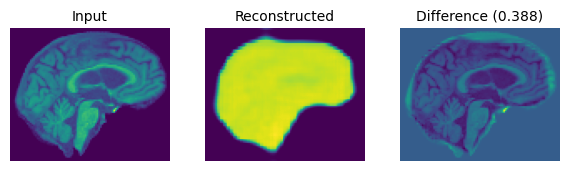

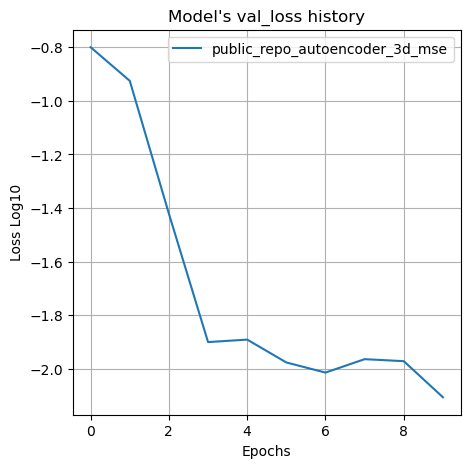

In [67]:
#models_list2d = [E5] #[A9,A6,A7] #[E,E2] #, B0, B1, B2]
#models_list = models_list2d
if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=g["CN"], loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))